# Topic Model Analysis

Todo: 1. industry : cusip to naics mapping 2. Topic evloution

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from compute_topic import *
from manage_path import *
from topic_model_analysis import *

import plotly
plotly.offline.init_notebook_mode(connected=True) 
import plotly.graph_objs as go
import plotly.io as pio
from itertools import repeat

import multiprocessing
from collections import deque

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import OrderedDict

## Topic Evolution
1. Dc_v1: 1 document for buy and sell, per dealer, per day.
2. Dc_v2: 1 document for buy and 1 document for sell, per dealer, per day.
3. Dc_v3: Either DC_v1 or DC_v2 without the 2 (4) documents representing the Source_seller and Source_buyer.
4. Tc_v1: 1 document for (buyer,seller,year)

In [2]:
result_directory = get_result_directory()
get_document_item_vectorize = np.vectorize(get_document_item)
#topic_matrix['dealer'] = pd.Series(list(zip(get_document_item_vectorize(topic.index,0),get_document_item_vectorize(topic.index,1)))).values

### Dc_v4

In [3]:
df = pd.read_csv(result_directory/'Dc_v4_75topics.csv',index_col=0)

In [4]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,66,67,68,69,70,71,72,73,74,75
"10,2014-01-07,BfC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,2014-02-07,BfC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,2014-04-10,BfC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.402667,NaN


In [5]:
df['dealer'] = pd.Series(list(zip(get_document_item_vectorize(df.index,0),get_document_item_vectorize(df.index,2)))).values
df.index = pd.to_datetime(get_document_item_vectorize(df.index,1))

In [6]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,dealer
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, BfC)"
2014-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, BfC)"
2014-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.402667,NaN,"(10, BfC)"


In [7]:
df_topicXtime_sum = df.groupby(by=df.index).sum()

In [8]:
#Dc_v3.groupby(by=Dc_v3.index).sum().to_csv('Dc_v3_50topics_topicXtime_sum.csv')

In [9]:
model_name = "Dc_v4"
heatmap_data = [
    go.Heatmap(
        z=df_topicXtime_sum.values.tolist(),
        #zmin=0,
        #zmax=1,
        x=df_topicXtime_sum.columns,
        y=df_topicXtime_sum.index,
        colorscale='Jet',
    )
]

layout = go.Layout(
    title='Dc_v4_75topics_topicXtime_sum_of_probability_weighting',
    xaxis={'title':'TopicID'},
    yaxis={'title':'Time'},
    width=980,
    height=540,
    #zaxis={'title':'Weighting Sum'},
)

fig = go.Figure(data=heatmap_data, layout=layout)
pio.write_image(fig, str("Dc_v4_75topics_topicXtime_sum.png"))

In [18]:
model_name = "Dc_v4"
heatmap_data = [
    go.Heatmap(
        z=preprocessing.minmax_scale(df_topicXtime_sum,feature_range=(0, 10)),
        #zmin=0,
        #zmax=1,
        x=df_topicXtime_sum.columns,
        y=df_topicXtime_sum.index,
        colorscale='Jet',
    )
]

layout = go.Layout(
    title='Dc_v4_75topics_topicXtime_sum_of_probability_weighting_with_scaling',
    xaxis={'title':'TopicID'},
    yaxis={'title':'Time'},
    width=980,
    height=540,
    #zaxis={'title':'Weighting Sum'},
)

fig = go.Figure(data=heatmap_data, layout=layout)
pio.write_image(fig, str("Dc_v4_75topics_topicXtime_sum_with_scaling.png"))

In [11]:
df_topicXtime_count = df.groupby(by=df.index).count().drop('dealer',axis=1)#[Dc_v3.columns[0:2]]

In [12]:
#Dc_v3.groupby(by=Dc_v3.index).count().to_csv('Dc_v3_50topics_topicXtime_count.csv')

In [13]:
model_name = "Dc_v4"
heatmap_data = [
    go.Heatmap(
        z=df_topicXtime_count.values.tolist(),
        #zmin=0,
        #zmax=1,
        x=df_topicXtime_count.columns,
        y=df_topicXtime_count.index,
        colorscale='Jet',
    )
]

layout = go.Layout(
    title='Dc_v4_75topics_topicXtime_count_of_documents',
    xaxis={'title':'TopicID'},
    yaxis={'title':'Time'},
    #zaxis={'title':'Weighting Sum'},
    width=980,
    height=540,
)

fig = go.Figure(data=heatmap_data, layout=layout)
pio.write_image(fig, str("Dc_v4_75topics_topicXtime_count.png"))

In [19]:
model_name = "Dc_v4"
heatmap_data = [
    go.Heatmap(
        z=preprocessing.minmax_scale(df_topicXtime_count,feature_range=(0, 10)),
        #zmin=0,
        #zmax=1,
        x=df_topicXtime_count.columns,
        y=df_topicXtime_count.index,
        colorscale='Jet',
    )
]

layout = go.Layout(
    title='Dc_v4_75topics_topicXtime_count_of_documents_with_scaling',
    xaxis={'title':'TopicID'},
    yaxis={'title':'Time'},
    #zaxis={'title':'Weighting Sum'},
    width=980,
    height=540,
)

fig = go.Figure(data=heatmap_data, layout=layout)
pio.write_image(fig, str("Dc_v4_75topics_topicXtime_count_with_scaling.png"))

C:\Users\raymo\Anaconda3\envs\topicModeling\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

Data with input dtype int64 were all converted to float64.



In [15]:
df_topicXtime_sum.to_csv("Dc_v4_75topics_topicXtime_sum.csv")
df_topicXtime_count.to_csv("Dc_v4_75topics_topicXtime_count.csv")

In [16]:
df_topicXtime_count.sum().describe()

count       75.000000
mean      5066.733333
std       3601.900566
min       1437.000000
25%       2824.500000
50%       3974.000000
75%       5419.000000
max      16869.000000
dtype: float64

In [17]:
df_topicXtime_count.sum(axis=1).describe()

count     259.000000
mean     1467.200772
std       313.787821
min         1.000000
25%      1451.000000
50%      1528.000000
75%      1603.000000
max      1838.000000
dtype: float64

### topicXtime heatmap

#### Try Plotly

In [ ]:
#ax = sns.heatmap(topic_matrix.values.tolist(),vmin=0,vmax=1,center=0.5)

In [ ]:
count_matrix = topic_matrix.groupby(["dealer"]).count()

In [ ]:
summary = topic_matrix.describe().T

In [ ]:
summary['mean'].plot()

In [ ]:
def get_dealer_by_ID(matrix,dealer_id,matrix_name):
    result = matrix.loc[matrix['dealer'] == dealer_id].copy().drop(labels='dealer',axis=1)
    return (result,dealer_id,matrix_name)

In [ ]:
dealer_df_list = list(map(lambda x: get_dealer_by_ID(topic_matrix,x,"Dc_v1"),list(topic_matrix['dealer'].unique())))
len(dealer_df_list)

In [ ]:
#deque(map(topicXtime,dealer_df_list))

In [ ]:
pio.orca.config
plotly.io.orca.status

cpu_cores = multiprocessing.cpu_count() - 1
pool = multiprocessing.Pool(cpu_cores)
pool.map(topicXtime_plotly_parallel,dealer_df_list)
pool.close()

#### Try mapplotlib

In [ ]:
cpu_cores = int(multiprocessing.cpu_count()/2) -1
pool = multiprocessing.Pool(cpu_cores)

In [ ]:
pool.starmap(topicXtime_matplotlib,dealer_df_list)
pool.close()

#### Try Seaborn

In [ ]:
sns.set()

In [ ]:
month_list = list(OrderedDict.fromkeys(dealer_df_list[0][0].index.strftime('%Y-%m')))

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T.values,vmin=0,vmax=1,center=0.5,xticklabels=[0,50,100,150,200,250],yticklabels=month_list)

num_x_ticks = 5
# the index of the position of yticks
xticks = np.linspace(0, len(dealer_df_list[0][0].columns) - 1, num_x_ticks, dtype=np.int)

num_y_ticks = len(month_list)
# the index of the position of yticks
yticks = np.linspace(0, len(dealer_df_list[0][0].index) - 1, num_y_ticks, dtype=np.int)

#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
ax.set_autoscaley_on(True)
ax.set_title('test')

In [ ]:
import matplotlib.dates as mdates
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())

#ax.set_xlim(dealer_df_list[0][0].index[0], dealer_df_list[0][0].index[-1])
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

figure = ax.get_figure()
figure.savefig('test.png', dpi=400)

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

In [ ]:
dealer_df_list[0][0].index[-1]

In [ ]:
yticks

In [ ]:
xticks

In [ ]:
figure = ax.get_figure()
figure.savefig('test.png', dpi=400)
#figure.savefig('test.svg', format="svg")

In [ ]:
ax.fig.autofmt_ydate()

In [ ]:
topic_matrix.corr().head()

## Topic Terms Distribution
Below is the topic terms ditrutbution demo. Since we already got Document X Topics, we want to have a Topic X Terms too.

In [ ]:
num_topics = 50
model = load_model('Dc_v3',num_topics)

In [ ]:
topic_terms_distribution = pd.DataFrame(model.get_topics())

In [ ]:
topic_terms_distribution.head()

## Industy Analysis

In [6]:
data_path = get_pickle_directory() / 'TRACE2014_jinming.pkl'
data = pd.read_pickle(data_path)

In [7]:
data.columns

Index(['TRD_RPT_DTTM', 'TRD_EXCTN_DTTM', 'TRC_ST', 'BOND_SYM_ID', 'CUSIP_ID',
       'SCRTY_TYPE_CD', 'ENTRD_VOL_QT', 'RPTD_PR', 'RPT_SIDE_CD',
       'Report_Dealer_Index', 'Contra_Party_Index', 'document_date',
       'ISSUER_ID', 'COMPLETE_CUSIP', 'AGENT_ID', 'CUSIP_NAME',
       'INDUSTRY_GROUP', 'INDUSTRY_CODE', 'PARENT_ID', 'NAICS_CODE',
       'SIC_CODE'],
      dtype='object')

In [8]:
print("We have {} rows of data".format(data.shape[0]))

We have 6322794 rows of data


In [9]:
def fix_NAICS_Code(NAICS_Code):
    "Fix the problem that FISD omits 0 if NAICS_Code ends with 0"
    if len(str(NAICS_Code))==5:
        NAICS_Code = NAICS_Code+'0'
    return NAICS_Code
fix_NAICS_Code_vectorize = np.vectorize(fix_NAICS_Code)
data['NAICS_CODE'] = fix_NAICS_Code_vectorize(data['NAICS_CODE'].values)

In [10]:
data = data[['BOND_SYM_ID', 'INDUSTRY_GROUP', 'INDUSTRY_CODE', 'PARENT_ID', 'NAICS_CODE','SIC_CODE']].copy()

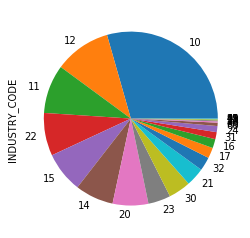

In [11]:
data['INDUSTRY_CODE'].value_counts().plot.pie()

In [12]:
# Get the NAICS_code lookup table
NAICS_code_path = get_dataset_directory() / 'NAICS_Code_Lookup.csv'
NAICS_code = pd.read_csv(NAICS_code_path,dtype={'Code':str,'Description':str})

In [13]:
# Group by BOND_SYM_ID and NAICS_CODE of 
NAICS_CODE_count = data['NAICS_CODE'].value_counts()
# Series to DataFrame
NAICS_CODE_count = NAICS_CODE_count.to_frame(name='count')

In [14]:
NAICS_code_total = NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)
NAICS_code_total['percentage'] = NAICS_code_total['count']/data.shape[0]

In [21]:
NAICS_code_total

,Code,Description,count,percentage
707,517311,Wired Telecommunications Carriers,425930,6.736421e-02
718,522110,Commercial Banking,392970,6.215132e-02
62,211120,Crude Petroleum Extraction,318156,5.031889e-02
99,221122,Electric Power Distribution,235101,3.718309e-02
257,325412,Pharmaceutical Preparation Manufacturing,169589,2.682184e-02
398,334111,Electronic Computer Manufacturing,169143,2.675131e-02
85,213111,Drilling Oil and Gas Wells,158685,2.509729e-02
237,324110,Petroleum Refineries,140122,2.216141e-02
731,523110,Investment Banking and Securities Dealing,134566,2.128268e-02
706,515210,Cable and Other Subscription Programming,122260,1.933639e-02


In [16]:
(NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)['count']/data.shape[0]).sum()

0.9760148757021025

In [17]:
data.groupby(by=['NAICS_CODE'])['BOND_SYM_ID'].nunique().sort_values(ascending=False).head()

NAICS_CODE
522110    1078
221122    1050
211120     487
517311     374
325412     236
Name: BOND_SYM_ID, dtype: int64

In [18]:
data.groupby(by=['BOND_SYM_ID'])

In [19]:
Bond_X_Industry = data.drop_duplicates(['BOND_SYM_ID'])

In [20]:
Bond_X_Industry.sort_values(by=['BOND_SYM_ID']).head()

,BOND_SYM_ID,INDUSTRY_GROUP,INDUSTRY_CODE,PARENT_ID,NAICS_CODE,SIC_CODE
8475,A.GC,1,10,46935,334515,3825
8531,A.GE,1,10,46935,334515,3825
8496,A.GF,1,10,46935,334515,3825
8539,A3900782,1,10,46935,334515,3825
109935,A4020252,1,10,46935,334515,3825


## Individual Check

## Convergence Test

In [ ]:
import re
import matplotlib.pyplot as plt
def convergence_likelyhood(model_name,num_topics):
    p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    matches = [p.findall(l) for l in open('../LDAModel/{}_{}topics.log.txt'.format(model_name,num_topics))]
    matches = [m for m in matches if len(m) > 0]
    tuples = [t[0] for t in matches]
    perplexity = [float(t[1]) for t in tuples]
    liklihood = [float(t[0]) for t in tuples]
    iter = list(range(0,len(tuples)*10,10))
    plt.plot(iter,liklihood,c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.savefig("{}_{}topics.pdf".format(model_name,num_topics))
    plt.close()

In [ ]:
#convergence_likelyhood("matrix_1",250)